In [2]:
import os
import numpy as np
import pandas as pd
import pickle
import json

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Activation, Dropout
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# If you have more than 1 GPU, you might want to specify which GPU for training.
# In this case, I have 2 GPU and the second one is RTX 2080ti, so I pick the `second` one.
os.environ['CUDA_VISIBLE_DEVICES']='0' # The second
tf.config.set_soft_device_placement(True)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


# Constants

In [3]:
d_name = '20211116_wmt19_en_zh'
folder_name = '20211122_translate_mle_en_zh_lstm'

encoder_wv_dim = 32
decoder_wv_dim = 32
encoder_que_pad = 65
decoder_que_pad = 207

In [4]:
if not os.path.isdir(folder_name):
    os.makedirs(folder_name)

# Load data

In [5]:
encoder_train = pickle.load(open(f'{d_name}/encoder_train.pkl', 'rb'))
decoder_train = pickle.load(open(f'{d_name}/decoder_train.pkl', 'rb'))
teacher_train = pickle.load(open(f'{d_name}/teacher_train.pkl', 'rb'))
encoder_vali  = pickle.load(open(f'{d_name}/encoder_vali.pkl', 'rb'))
decoder_vali  = pickle.load(open(f'{d_name}/decoder_vali.pkl', 'rb'))
teacher_vali  = pickle.load(open(f'{d_name}/teacher_vali.pkl', 'rb'))

decoder_idx2word   = pickle.load(open(f'{d_name}/en_idx2word.pkl','rb'))
decoder_word2idx   = pickle.load(open(f'{d_name}/en_word2idx.pkl','rb'))
encoder_idx2word   = pickle.load(open(f'{d_name}/zh_idx2word.pkl','rb'))
encoder_word2idx   = pickle.load(open(f'{d_name}/zh_word2idx.pkl','rb'))

decoder_emb32   = pickle.load(open(f'{d_name}/en_emb32.pkl', 'rb'))
encoder_emb32   = pickle.load(open(f'{d_name}/zh_emb32.pkl', 'rb'))

In [6]:
print(encoder_train.shape)
print(teacher_train.shape)

(221040, 65)
(221040, 207)


In [6]:
num_decoder_words = np.max([np.max(decoder_train), np.max(decoder_vali)])+1
num_encoder_words = np.max([np.max(encoder_train), np.max(encoder_vali)])+1

print(num_decoder_words)
print(num_encoder_words)

199
4716


In [7]:
def seq2word(seq_tensor, idx2word):
    return [''.join([idx2word[i] for i in seq]) for seq in seq_tensor]

In [8]:
seq2word(decoder_vali[:1], decoder_idx2word)

['<bos>1929 or 1989?<eos>                                                                                                                                                                                                ']

In [9]:
seq2word(encoder_vali[:1], encoder_idx2word)

['1929年还是1989年?                                                    ']

# Positional Encoding
[Positional Encoding](https://www.tensorflow.org/text/tutorials/transformer)
based on [Vaswani+17, Attention is All You Need](https://arxiv.org/abs/1706.03762)

In [10]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 10, 64)


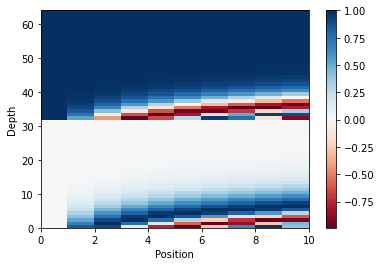

In [11]:
from matplotlib import pyplot as plt
n, d = 10, 64
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

# Generator

[Multi-Head Attention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) 
and [Positional Encoding](https://www.tensorflow.org/text/tutorials/transformer)
based on [Vaswani+17, Attention is All You Need](https://arxiv.org/abs/1706.03762)

In [12]:
def Transformer(q_que_pad, k_que_pad, wv_dim, k_wv_dim, rate = 0.1, mask = ''):
    # Inputs
    mem  = Input((q_que_pad, wv_dim))
    encode = Input((k_que_pad, k_wv_dim))
    # Constants
    ff_dim = wv_dim*64
    # Multi-Head Attention
    q = Dense(wv_dim)(mem)
    k = Dense(wv_dim)(encode)
    v = Dense(wv_dim)(encode)
    # Choose a mask, default: BERT (no mask)
    mask_weights = np.ones((q_que_pad, k_que_pad))
    if mask == 'GPT':
        mask_weights = np.tri(q_que_pad, k_que_pad, 0)
    mem_new = MultiHeadAttention(
        num_heads = 4,
        key_dim = wv_dim, 
        value_dim = wv_dim
    )(
        q, k, v,
        attention_mask = mask_weights
    )
    mem_new = Dropout(rate)(mem_new)
    mem_new = LayerNormalization(epsilon=1e-6)(mem_new+mem)
    # Feed-Forward skip-connection
    ffn = Dense(ff_dim, activation = 'relu')(mem_new)
    ffn = Dense(wv_dim)(ffn)
    ffn = Dropout(rate)(ffn)
    out = LayerNormalization(epsilon=1e-6)(ffn+mem_new)
    model = Model(
        [mem, encode],
        [mem_new, out],
    )
    return model

def getE(wv_dim = 16):
    _input = Input((encoder_que_pad,))
    emb = Embedding(
        num_encoder_words, 
        wv_dim, 
        mask_zero = False,
        input_length=(int(encoder_que_pad)),
        trainable = True,
        embeddings_initializer=tf.keras.initializers.Constant(encoder_emb32),
    )
    mem = emb(_input)
    # position encoding
    pe = positional_encoding(encoder_que_pad, wv_dim)
    mem = LayerNormalization(epsilon=1e-6)(mem+pe)
    # forward sentence
    for i in range(1):
        #gptLayer = Transformer(encoder_que_pad, encoder_que_pad, wv_dim, wv_dim)
        #mem, output = gptLayer((mem, mem))
        #output = Activation('relu')(output)
        #mem = Activation('relu')(mem)
        lstmLayer = LSTM(32, return_sequences=True)
        mem = lstmLayer(mem)
    # Output
    output = mem
    model = Model(
        _input, 
        output) 
    return model

def getD(wv_dim = 8, encoder_wv_dim = 16):
    en_output = Input((encoder_que_pad, encoder_wv_dim))
    de_input  = Input((decoder_que_pad,))
    emb = Embedding(
        num_decoder_words, 
        wv_dim, 
        mask_zero = False,
        input_length=(int(decoder_que_pad)),
        trainable = True,
        embeddings_initializer=tf.keras.initializers.Constant(decoder_emb32),
    )
    mem = emb(de_input)
    # position encoding
    pe = positional_encoding(decoder_que_pad, wv_dim)
    mem = LayerNormalization(epsilon=1e-6)(mem+pe)
    # Attention
    for j in range(1):
        # Self attention
        for i in range(1):
            #gptLayer = Transformer(decoder_que_pad, decoder_que_pad, wv_dim, wv_dim, mask = 'GPT')
            #mem, _ = gptLayer((mem, mem))
            #mem = Activation('relu')(mem)
            lstmLayer = LSTM(32, return_sequences=True)
            mem = lstmLayer(mem)
        # Cross attention
        for i in range(1):
            gptLayer = Transformer(decoder_que_pad, encoder_que_pad, wv_dim, encoder_wv_dim)
            mem, output = gptLayer((mem, en_output))
            output = Activation('relu')(output)
            mem = Activation('relu')(mem)
    # Concatenation and output
    output = Dense(num_decoder_words)(output)
    output = Activation('softmax')(output)
    model = Model(
        [en_output, de_input], 
        output,
    )
    return model

# Language Model
def getLM():
    # Inputs
    en_input = Input((encoder_que_pad,))
    de_input = Input((decoder_que_pad,))
    # Encoder (Chinese -> code)
    encoder = getE(encoder_wv_dim)
    encoder.summary()
    en_output = encoder(en_input)
    # Decoder (code -> English)
    decoder = getD(decoder_wv_dim, encoder_wv_dim)
    decoder.summary()
    de_output = decoder([en_output, de_input])
    # Establish the model
    model = Model(
        [en_input, de_input],
        de_output,
    )
    return model

In [13]:
mleG = getLM()
mleG.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy'],
)
mleG.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 65)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 65, 32)            150912    
_________________________________________________________________
tf.__operators__.add (TFOpLa (None, 65, 32)            0         
_________________________________________________________________
layer_normalization (LayerNo (None, 65, 32)            64        
_________________________________________________________________
lstm (LSTM)                  (None, 65, 32)            8320      
Total params: 159,296
Trainable params: 159,296
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
__________________________________________________________________________________________________
Layer

In [14]:
mleG.fit(
    [encoder_train, decoder_train], 
    teacher_train, 
    batch_size=128, 
    epochs=300, 
    shuffle=True, 
    validation_data = (
        [encoder_vali, decoder_vali], 
        teacher_vali
    ), 
    callbacks=[
        ModelCheckpoint(
            f'./{folder_name}/mleG.h5', 
            save_best_only=True, 
            monitor = "val_loss"
        ),
        EarlyStopping(monitor='val_loss', patience=5),
        CSVLogger(f'{folder_name}/mleG.csv'),
    ]
)

Epoch 1/300
1727/1727 [==============================] - 59s 33ms/step - loss: 1.3985 - accuracy: 0.6304 - val_loss: 0.9930 - val_accuracy: 0.7063
Epoch 2/300
1727/1727 [==============================] - 55s 32ms/step - loss: 0.9213 - accuracy: 0.7273 - val_loss: 0.8354 - val_accuracy: 0.7507
Epoch 3/300
1727/1727 [==============================] - 55s 32ms/step - loss: 0.8340 - accuracy: 0.7508 - val_loss: 0.7888 - val_accuracy: 0.7622
Epoch 4/300
1727/1727 [==============================] - 55s 32ms/step - loss: 0.7946 - accuracy: 0.7614 - val_loss: 0.7568 - val_accuracy: 0.7719
Epoch 5/300
1727/1727 [==============================] - 55s 32ms/step - loss: 0.7703 - accuracy: 0.7682 - val_loss: 0.7328 - val_accuracy: 0.7785
Epoch 6/300
1727/1727 [==============================] - 55s 32ms/step - loss: 0.7507 - accuracy: 0.7741 - val_loss: 0.7181 - val_accuracy: 0.7831
Epoch 7/300
1727/1727 [==============================] - 55s 32ms/step - loss: 0.7335 - accuracy: 0.7798 - val_loss: 0

1727/1727 [==============================] - 68s 39ms/step - loss: 0.5685 - accuracy: 0.8321 - val_loss: 0.5466 - val_accuracy: 0.8379


In [15]:
mleG.load_weights(f'./{folder_name}/mleG.h5')
loss, _acc = mleG.evaluate(
    [encoder_vali, decoder_vali], 
    teacher_vali
)
print(loss)

768/768 [==============================] - 10s 14ms/step - loss: 0.5462 - accuracy: 0.8382
0.5462390780448914


No handles with labels found to put in legend.


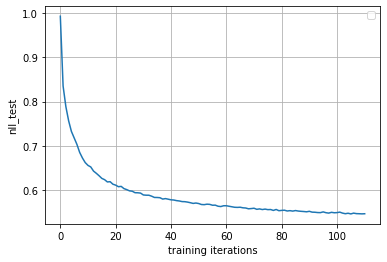

In [16]:
import csv
from matplotlib import pyplot as plt
%matplotlib inline
rows = csv.reader(open(f'{folder_name}/mleG.csv'))
nll_mle = []
for i, row in enumerate(rows):
    if i == 0:
        continue
    nll_mle.append(float(row[-1]))
plt.plot(nll_mle, )
plt.grid(True)
plt.ylabel('nll_test')
plt.xlabel('training iterations')
plt.legend()
plt.show()

## Inference train D (False) 

In [ ]:
def inference(
    model,
    enData = None,
):
    # Initialize
    resp_pred_list = None
    in_batch_list = None
    the_first = True
    
    in_batch = np.zeros((len(enData), decoder_que_pad), dtype = int)
    in_batch[:,0] = decoder_word2idx['<bos>']
    en_batch = enData
    resp_pred = np.zeros(in_batch.shape, dtype = int)
    # Generate the sequence recurrsively.
    for i in range(decoder_que_pad):
        # Run
        resp_pred_wv = model([en_batch, in_batch])
        the_last = resp_pred_wv[:,i]
        # Stochastic
        the_last_one = tf.reshape(
            tf.random.categorical(tf.math.log(the_last), 1), 
            [len(enData),]
        )
        # TODO: greedy
        the_last_two = tf.math.argmax(the_last, axis = 1)
        try:
            resp_pred[:,i] = the_last_one
            in_batch[:,i+1] = the_last_one
        except:
            resp_pred[:,i] = the_last_one
    # Remove the words after <eos>
    for i in range(len(resp_pred)):
        try:
            index = list(resp_pred[i]).index(en_word2idx['<eos>'])
        except:
            continue
        resp_pred[i,index+1:] = 0
        in_batch[i,index+1:] = 0
        
    return resp_pred, in_batch

In [ ]:
resp_pred_list, _ = inference(mleG, [encoder_vali[123]])
print('# Predicted sequence')
print(seq2word(resp_pred_list, decoder_idx2word))
print('# Real sequence')
print(seq2word([decoder_vali[123]], decoder_idx2word))

# Step 2: Slow MLE

In [19]:
mleG = getLM()
mleG.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate = 1e-5),
    metrics=['accuracy'],
)
mleG.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 65)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 65, 32)            150912    
_________________________________________________________________
tf.__operators__.add_4 (TFOp (None, 65, 32)            0         
_________________________________________________________________
layer_normalization_4 (Layer (None, 65, 32)            64        
_________________________________________________________________
lstm_2 (LSTM)                (None, 65, 32)            8320      
Total params: 159,296
Trainable params: 159,296
Non-trainable params: 0
_________________________________________________________________
Model: "model_6"
__________________________________________________________________________________________________
Lay

In [20]:
mleG.load_weights(f'./{folder_name}/mleG.h5')
loss, _acc = mleG.evaluate(
    [encoder_vali, decoder_vali], 
    teacher_vali
)
print(loss)

768/768 [==============================] - 11s 13ms/step - loss: 0.5462 - accuracy: 0.8382
0.5462390780448914


In [ ]:
mleG.fit(
    [encoder_train, decoder_train], 
    teacher_train, 
    batch_size=128, 
    epochs=300, 
    shuffle=True, 
    validation_data = (
        [encoder_vali, decoder_vali], 
        teacher_vali
    ), 
    callbacks=[
        ModelCheckpoint(
            f'./{folder_name}/slowmleG.h5', 
            save_best_only=True, 
            monitor = "val_loss"
        ),
        EarlyStopping(monitor='val_loss', patience=5),
        CSVLogger(f'{folder_name}/slowmleG.csv'),
    ]
)

Epoch 1/300
1727/1727 [==============================] - 70s 39ms/step - loss: 0.5576 - accuracy: 0.8353 - val_loss: 0.5362 - val_accuracy: 0.8411
Epoch 2/300
1727/1727 [==============================] - 67s 39ms/step - loss: 0.5559 - accuracy: 0.8358 - val_loss: 0.5356 - val_accuracy: 0.8412
Epoch 3/300
1727/1727 [==============================] - 67s 39ms/step - loss: 0.5555 - accuracy: 0.8359 - val_loss: 0.5354 - val_accuracy: 0.8413
Epoch 4/300
1727/1727 [==============================] - 67s 39ms/step - loss: 0.5552 - accuracy: 0.8360 - val_loss: 0.5351 - val_accuracy: 0.8415
Epoch 5/300
1727/1727 [==============================] - 67s 39ms/step - loss: 0.5549 - accuracy: 0.8360 - val_loss: 0.5350 - val_accuracy: 0.8414
Epoch 6/300
1727/1727 [==============================] - 67s 39ms/step - loss: 0.5548 - accuracy: 0.8361 - val_loss: 0.5349 - val_accuracy: 0.8415
Epoch 7/300
1727/1727 [==============================] - 68s 39ms/step - loss: 0.5547 - accuracy: 0.8361 - val_loss: 0

No handles with labels found to put in legend.


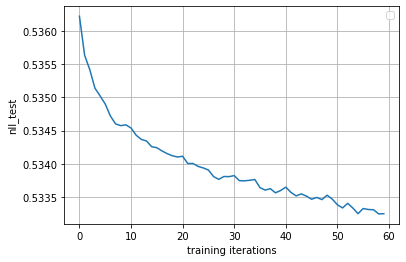

In [7]:
import csv
from matplotlib import pyplot as plt
%matplotlib inline
rows = csv.reader(open(f'{folder_name}/slowmleG.csv'))
nll_mle = []
for i, row in enumerate(rows):
    if i == 0:
        continue
    nll_mle.append(float(row[-1]))
plt.plot(nll_mle, )
plt.grid(True)
plt.ylabel('nll_test')
plt.xlabel('training iterations')
plt.legend()
plt.show()

In [23]:
mleG.load_weights(f'./{folder_name}/slowmleG.h5')
loss, _acc = mleG.evaluate(
    [encoder_vali, decoder_vali], 
    teacher_vali
)
print(loss)

768/768 [==============================] - 11s 14ms/step - loss: 0.5332 - accuracy: 0.8420
0.5332431793212891


In [28]:
resp_pred_list, _ = inference(mleG, [encoder_vali[123]])
print('# Predicted sequence')
print(seq2word(resp_pred_list, decoder_idx2word))
print('# Real sequence')
print(seq2word([decoder_vali[123]], decoder_idx2word))

# Predicted sequence
['Even to the its year for-year.<eos>                                                                                                                                                                                ']
# Real sequence
['<bos>The coming year will be particularly important for Europe.<eos>                                                                                                                                                   ']
